## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)
net = net.cuda()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.3, in

In [3]:
from torchsummary import summary

In [4]:
print(summary(net,(1, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             320
            Conv2d-2         [-1, 64, 222, 222]          18,432
       BatchNorm2d-3         [-1, 64, 222, 222]             128
         MaxPool2d-4         [-1, 64, 111, 111]               0
            Conv2d-5        [-1, 128, 111, 111]          73,728
       BatchNorm2d-6        [-1, 128, 111, 111]             256
         MaxPool2d-7          [-1, 128, 55, 55]               0
            Conv2d-8          [-1, 256, 55, 55]         294,912
       BatchNorm2d-9          [-1, 256, 55, 55]             512
        MaxPool2d-10          [-1, 256, 27, 27]               0
           Conv2d-11          [-1, 256, 27, 27]         589,824
      BatchNorm2d-12          [-1, 256, 27, 27]             512
        MaxPool2d-13          [-1, 256, 13, 13]               0
          Dropout-14          [-1, 256,

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor

In [6]:
## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()
    
])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [7]:
# create the transformed dataset
root_folder = '/scratch/prathyuakundi/Udacity/CV/P1_Facial_Keypoints/'
transformed_dataset = FacialKeypointsDataset(csv_file=root_folder+'data/training_frames_keypoints.csv',
                                             root_dir=root_folder+'data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [8]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [9]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file=root_folder+'data/test_frames_keypoints.csv',
                                             root_dir=root_folder+'data/test/',
                                             transform=data_transform)



In [10]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [11]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)
        images = images.cuda()
        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [12]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [13]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

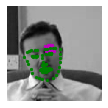

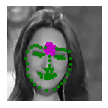

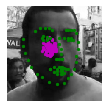

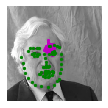

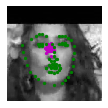

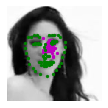

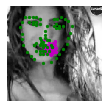

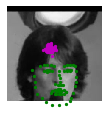

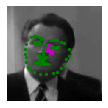

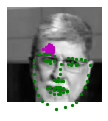

In [14]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [16]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(params = net.parameters(), lr = 0.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [17]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()
    losses = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            images = images.cuda()
            key_pts = key_pts.cuda()
            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
        
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                
                running_loss = 0.0
        losses.append(running_loss)
    print('Finished Training')
    return losses


In [18]:
# train your network
n_epochs = 50 # start small, and increase when you've decided on your model structure and hyperparams

losses = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.01063066965341568
Epoch: 1, Batch: 20, Avg. Loss: 0.0012423870265483856
Epoch: 1, Batch: 30, Avg. Loss: 0.0012600399628281593
Epoch: 1, Batch: 40, Avg. Loss: 0.0011226554736495017
Epoch: 1, Batch: 50, Avg. Loss: 0.0010119959712028503
Epoch: 1, Batch: 60, Avg. Loss: 0.0009684174582362175
Epoch: 1, Batch: 70, Avg. Loss: 0.0009317645207047462
Epoch: 1, Batch: 80, Avg. Loss: 0.0010111482217907905
Epoch: 1, Batch: 90, Avg. Loss: 0.000948572039604187
Epoch: 1, Batch: 100, Avg. Loss: 0.0010392810255289077
Epoch: 1, Batch: 110, Avg. Loss: 0.0009430777914822101
Epoch: 1, Batch: 120, Avg. Loss: 0.0009370025955140591
Epoch: 1, Batch: 130, Avg. Loss: 0.0010944500602781773
Epoch: 1, Batch: 140, Avg. Loss: 0.0010182571783661843
Epoch: 1, Batch: 150, Avg. Loss: 0.0011017774939537047
Epoch: 1, Batch: 160, Avg. Loss: 0.0009246306791901588
Epoch: 1, Batch: 170, Avg. Loss: 0.0009653122536838055
Epoch: 1, Batch: 180, Avg. Loss: 0.0009870343171060085
Epoch: 1, Batch: 190, 

Epoch: 5, Batch: 150, Avg. Loss: 0.00021267184987664223
Epoch: 5, Batch: 160, Avg. Loss: 0.00038408746756613254
Epoch: 5, Batch: 170, Avg. Loss: 0.00029334890469908715
Epoch: 5, Batch: 180, Avg. Loss: 0.0001584683693945408
Epoch: 5, Batch: 190, Avg. Loss: 0.00026332296431064606
Epoch: 5, Batch: 200, Avg. Loss: 0.0002991527123376727
Epoch: 5, Batch: 210, Avg. Loss: 0.00031605033669620755
Epoch: 5, Batch: 220, Avg. Loss: 0.00038120174594223497
Epoch: 5, Batch: 230, Avg. Loss: 0.0003131646551191807
Epoch: 5, Batch: 240, Avg. Loss: 0.0002374519295990467
Epoch: 5, Batch: 250, Avg. Loss: 0.0005532612483948469
Epoch: 5, Batch: 260, Avg. Loss: 0.0002953508794307709
Epoch: 5, Batch: 270, Avg. Loss: 0.00029630876053124666
Epoch: 5, Batch: 280, Avg. Loss: 0.00041514139994978906
Epoch: 5, Batch: 290, Avg. Loss: 0.00039741111733019354
Epoch: 5, Batch: 300, Avg. Loss: 0.0002560978550463915
Epoch: 5, Batch: 310, Avg. Loss: 0.0002369618508964777
Epoch: 5, Batch: 320, Avg. Loss: 0.0004794259946793318
E

Epoch: 9, Batch: 280, Avg. Loss: 0.00018092542514204979
Epoch: 9, Batch: 290, Avg. Loss: 0.0002873187093064189
Epoch: 9, Batch: 300, Avg. Loss: 0.00023964870255440473
Epoch: 9, Batch: 310, Avg. Loss: 0.0002745027765631676
Epoch: 9, Batch: 320, Avg. Loss: 0.00023036022204905748
Epoch: 9, Batch: 330, Avg. Loss: 0.0003098360374569893
Epoch: 9, Batch: 340, Avg. Loss: 0.0002292377930134535
Epoch: 10, Batch: 10, Avg. Loss: 0.00019844227656722069
Epoch: 10, Batch: 20, Avg. Loss: 0.00026771047245711087
Epoch: 10, Batch: 30, Avg. Loss: 0.00042705092392861845
Epoch: 10, Batch: 40, Avg. Loss: 0.00017841586470603943
Epoch: 10, Batch: 50, Avg. Loss: 0.0002609845558181405
Epoch: 10, Batch: 60, Avg. Loss: 0.00032087348587810994
Epoch: 10, Batch: 70, Avg. Loss: 0.00021011320687830447
Epoch: 10, Batch: 80, Avg. Loss: 0.0002614481654018164
Epoch: 10, Batch: 90, Avg. Loss: 0.00021068445034325123
Epoch: 10, Batch: 100, Avg. Loss: 0.00020890488661825656
Epoch: 10, Batch: 110, Avg. Loss: 0.00019349914789199

Epoch: 14, Batch: 40, Avg. Loss: 0.00022109557874500752
Epoch: 14, Batch: 50, Avg. Loss: 0.00017641620803624393
Epoch: 14, Batch: 60, Avg. Loss: 0.0001868959963321686
Epoch: 14, Batch: 70, Avg. Loss: 0.00019594119396060706
Epoch: 14, Batch: 80, Avg. Loss: 0.00017419944889843464
Epoch: 14, Batch: 90, Avg. Loss: 0.00023589300084859134
Epoch: 14, Batch: 100, Avg. Loss: 0.00016717005893588066
Epoch: 14, Batch: 110, Avg. Loss: 0.00014955560117959975
Epoch: 14, Batch: 120, Avg. Loss: 0.0003719076057896018
Epoch: 14, Batch: 130, Avg. Loss: 0.0002807403616607189
Epoch: 14, Batch: 140, Avg. Loss: 0.00025482768286019564
Epoch: 14, Batch: 150, Avg. Loss: 0.00021789157204329967
Epoch: 14, Batch: 160, Avg. Loss: 0.00021955860964953898
Epoch: 14, Batch: 170, Avg. Loss: 0.0005406425502151251
Epoch: 14, Batch: 180, Avg. Loss: 0.00020395601633936168
Epoch: 14, Batch: 190, Avg. Loss: 0.000225790336728096
Epoch: 14, Batch: 200, Avg. Loss: 0.00044192991498857734
Epoch: 14, Batch: 210, Avg. Loss: 0.0001744

Epoch: 18, Batch: 140, Avg. Loss: 0.00026064871670678256
Epoch: 18, Batch: 150, Avg. Loss: 0.00018431017361581324
Epoch: 18, Batch: 160, Avg. Loss: 0.00015876510925590993
Epoch: 18, Batch: 170, Avg. Loss: 0.00017394049745053053
Epoch: 18, Batch: 180, Avg. Loss: 0.00016014437004923822
Epoch: 18, Batch: 190, Avg. Loss: 0.0001581451604142785
Epoch: 18, Batch: 200, Avg. Loss: 0.000150610426440835
Epoch: 18, Batch: 210, Avg. Loss: 0.00011991875059902669
Epoch: 18, Batch: 220, Avg. Loss: 0.00014754767436534166
Epoch: 18, Batch: 230, Avg. Loss: 0.00012961014825850725
Epoch: 18, Batch: 240, Avg. Loss: 0.0001608434123918414
Epoch: 18, Batch: 250, Avg. Loss: 0.00025340106058865784
Epoch: 18, Batch: 260, Avg. Loss: 0.00017923606093972922
Epoch: 18, Batch: 270, Avg. Loss: 0.00028328524902462957
Epoch: 18, Batch: 280, Avg. Loss: 0.00016565051674842835
Epoch: 18, Batch: 290, Avg. Loss: 0.000167832275852561
Epoch: 18, Batch: 300, Avg. Loss: 0.0001380079761147499
Epoch: 18, Batch: 310, Avg. Loss: 0.00

Epoch: 22, Batch: 240, Avg. Loss: 0.00015217940323054792
Epoch: 22, Batch: 250, Avg. Loss: 0.00015003252122551203
Epoch: 22, Batch: 260, Avg. Loss: 0.00011748934164643288
Epoch: 22, Batch: 270, Avg. Loss: 0.00022641550563275815
Epoch: 22, Batch: 280, Avg. Loss: 0.00012846122216433287
Epoch: 22, Batch: 290, Avg. Loss: 0.00011943813366815448
Epoch: 22, Batch: 300, Avg. Loss: 0.00014227742282673717
Epoch: 22, Batch: 310, Avg. Loss: 0.0001535925343632698
Epoch: 22, Batch: 320, Avg. Loss: 0.00014137000357732177
Epoch: 22, Batch: 330, Avg. Loss: 0.00022599895298480987
Epoch: 22, Batch: 340, Avg. Loss: 0.00015395543165504932
Epoch: 23, Batch: 10, Avg. Loss: 0.00013961864169687033
Epoch: 23, Batch: 20, Avg. Loss: 0.00016541955806314944
Epoch: 23, Batch: 30, Avg. Loss: 0.00011987205082550645
Epoch: 23, Batch: 40, Avg. Loss: 0.0002254587858915329
Epoch: 23, Batch: 50, Avg. Loss: 0.00015902116242796184
Epoch: 23, Batch: 60, Avg. Loss: 0.0001501839365810156
Epoch: 23, Batch: 70, Avg. Loss: 0.00010

Epoch: 26, Batch: 340, Avg. Loss: 0.0004343463657423854
Epoch: 27, Batch: 10, Avg. Loss: 0.00025201005674898626
Epoch: 27, Batch: 20, Avg. Loss: 0.00011567066144198179
Epoch: 27, Batch: 30, Avg. Loss: 9.66971842572093e-05
Epoch: 27, Batch: 40, Avg. Loss: 0.0001258485708385706
Epoch: 27, Batch: 50, Avg. Loss: 0.00014527980051934718
Epoch: 27, Batch: 60, Avg. Loss: 0.00011332661844789982
Epoch: 27, Batch: 70, Avg. Loss: 0.00012019057990983128
Epoch: 27, Batch: 80, Avg. Loss: 9.618978714570403e-05
Epoch: 27, Batch: 90, Avg. Loss: 0.00010181823465973139
Epoch: 27, Batch: 100, Avg. Loss: 0.0001753744287416339
Epoch: 27, Batch: 110, Avg. Loss: 0.00010016270959749817
Epoch: 27, Batch: 120, Avg. Loss: 0.00012466542795300483
Epoch: 27, Batch: 130, Avg. Loss: 0.0001303911809809506
Epoch: 27, Batch: 140, Avg. Loss: 0.00012098502274602652
Epoch: 27, Batch: 150, Avg. Loss: 0.00013778708642348648
Epoch: 27, Batch: 160, Avg. Loss: 0.00017120477557182312
Epoch: 27, Batch: 170, Avg. Loss: 0.00016963193

Epoch: 31, Batch: 100, Avg. Loss: 0.00012978360150009394
Epoch: 31, Batch: 110, Avg. Loss: 9.903106465935707e-05
Epoch: 31, Batch: 120, Avg. Loss: 0.00010443433094769717
Epoch: 31, Batch: 130, Avg. Loss: 0.0001741898595355451
Epoch: 31, Batch: 140, Avg. Loss: 0.00016596756596118213
Epoch: 31, Batch: 150, Avg. Loss: 0.00010551571659743786
Epoch: 31, Batch: 160, Avg. Loss: 0.0001046288381330669
Epoch: 31, Batch: 170, Avg. Loss: 0.00010394471324980258
Epoch: 31, Batch: 180, Avg. Loss: 0.00010583636397495866
Epoch: 31, Batch: 190, Avg. Loss: 0.00010635573323816061
Epoch: 31, Batch: 200, Avg. Loss: 0.0003898970596492291
Epoch: 31, Batch: 210, Avg. Loss: 0.0002610157895833254
Epoch: 31, Batch: 220, Avg. Loss: 0.00012947282614186406
Epoch: 31, Batch: 230, Avg. Loss: 0.00011050941096618771
Epoch: 31, Batch: 240, Avg. Loss: 0.00022392920684069395
Epoch: 31, Batch: 250, Avg. Loss: 0.00010797920543700457
Epoch: 31, Batch: 260, Avg. Loss: 0.00010838076518848538
Epoch: 31, Batch: 270, Avg. Loss: 0.

Epoch: 35, Batch: 200, Avg. Loss: 0.00011182919656857849
Epoch: 35, Batch: 210, Avg. Loss: 0.00011262927670031786
Epoch: 35, Batch: 220, Avg. Loss: 9.409603383392095e-05
Epoch: 35, Batch: 230, Avg. Loss: 9.559747343882918e-05
Epoch: 35, Batch: 240, Avg. Loss: 0.00010423828708007931
Epoch: 35, Batch: 250, Avg. Loss: 0.00010478018876165152
Epoch: 35, Batch: 260, Avg. Loss: 0.00011583125032484531
Epoch: 35, Batch: 270, Avg. Loss: 0.00014633734989911317
Epoch: 35, Batch: 280, Avg. Loss: 0.00011936808889731765
Epoch: 35, Batch: 290, Avg. Loss: 0.00010850822925567626
Epoch: 35, Batch: 300, Avg. Loss: 0.00011303327139467002
Epoch: 35, Batch: 310, Avg. Loss: 0.00011225075367838144
Epoch: 35, Batch: 320, Avg. Loss: 0.00011178869707509876
Epoch: 35, Batch: 330, Avg. Loss: 0.00011715751979500056
Epoch: 35, Batch: 340, Avg. Loss: 0.0003675553724169731
Epoch: 36, Batch: 10, Avg. Loss: 0.00010166929056867957
Epoch: 36, Batch: 20, Avg. Loss: 0.00011049963673576713
Epoch: 36, Batch: 30, Avg. Loss: 0.0

Epoch: 39, Batch: 300, Avg. Loss: 0.00010719688376411795
Epoch: 39, Batch: 310, Avg. Loss: 0.00011249189171940088
Epoch: 39, Batch: 320, Avg. Loss: 9.322291845455766e-05
Epoch: 39, Batch: 330, Avg. Loss: 0.00014118947833776475
Epoch: 39, Batch: 340, Avg. Loss: 9.437095001339912e-05
Epoch: 40, Batch: 10, Avg. Loss: 0.00022188411746174098
Epoch: 40, Batch: 20, Avg. Loss: 0.00010961907776072621
Epoch: 40, Batch: 30, Avg. Loss: 0.00010286292526870966
Epoch: 40, Batch: 40, Avg. Loss: 9.879762213677167e-05
Epoch: 40, Batch: 50, Avg. Loss: 0.00012277896702289582
Epoch: 40, Batch: 60, Avg. Loss: 0.00010467615630477667
Epoch: 40, Batch: 70, Avg. Loss: 9.89258298650384e-05
Epoch: 40, Batch: 80, Avg. Loss: 0.00023652893537655473
Epoch: 40, Batch: 90, Avg. Loss: 9.32244211435318e-05
Epoch: 40, Batch: 100, Avg. Loss: 0.00010984843922778965
Epoch: 40, Batch: 110, Avg. Loss: 9.154021833091974e-05
Epoch: 40, Batch: 120, Avg. Loss: 0.00011177137913182378
Epoch: 40, Batch: 130, Avg. Loss: 0.000116212991

Epoch: 44, Batch: 70, Avg. Loss: 8.932276349514723e-05
Epoch: 44, Batch: 80, Avg. Loss: 0.00011357795167714357
Epoch: 44, Batch: 90, Avg. Loss: 9.54034449532628e-05
Epoch: 44, Batch: 100, Avg. Loss: 0.00018721960857510567
Epoch: 44, Batch: 110, Avg. Loss: 0.00012992072850465775
Epoch: 44, Batch: 120, Avg. Loss: 0.00012822610000148415
Epoch: 44, Batch: 130, Avg. Loss: 0.0001035718685016036
Epoch: 44, Batch: 140, Avg. Loss: 0.00010115178162232041
Epoch: 44, Batch: 150, Avg. Loss: 0.0001213390096090734
Epoch: 44, Batch: 160, Avg. Loss: 0.00013864344591274857
Epoch: 44, Batch: 170, Avg. Loss: 0.00011824736185371876
Epoch: 44, Batch: 180, Avg. Loss: 8.896539313718677e-05
Epoch: 44, Batch: 190, Avg. Loss: 9.247519914060831e-05
Epoch: 44, Batch: 200, Avg. Loss: 0.00010870610922574997
Epoch: 44, Batch: 210, Avg. Loss: 9.487117547541857e-05
Epoch: 44, Batch: 220, Avg. Loss: 8.701255358755588e-05
Epoch: 44, Batch: 230, Avg. Loss: 7.270807912573218e-05
Epoch: 44, Batch: 240, Avg. Loss: 8.74326615

Epoch: 48, Batch: 180, Avg. Loss: 9.005175111815333e-05
Epoch: 48, Batch: 190, Avg. Loss: 7.452034018933773e-05
Epoch: 48, Batch: 200, Avg. Loss: 0.00018377823615446686
Epoch: 48, Batch: 210, Avg. Loss: 8.503010682761669e-05
Epoch: 48, Batch: 220, Avg. Loss: 8.55772434733808e-05
Epoch: 48, Batch: 230, Avg. Loss: 0.0001503312587738037
Epoch: 48, Batch: 240, Avg. Loss: 8.287724433466792e-05
Epoch: 48, Batch: 250, Avg. Loss: 0.000220379242207855
Epoch: 48, Batch: 260, Avg. Loss: 0.00010399247519671918
Epoch: 48, Batch: 270, Avg. Loss: 0.00010555128799751401
Epoch: 48, Batch: 280, Avg. Loss: 9.776231506839394e-05
Epoch: 48, Batch: 290, Avg. Loss: 9.53916166909039e-05
Epoch: 48, Batch: 300, Avg. Loss: 7.035539019852876e-05
Epoch: 48, Batch: 310, Avg. Loss: 9.147028252482414e-05
Epoch: 48, Batch: 320, Avg. Loss: 8.779077930375934e-05
Epoch: 48, Batch: 330, Avg. Loss: 7.718420168384909e-05
Epoch: 48, Batch: 340, Avg. Loss: 8.86528161354363e-05
Epoch: 49, Batch: 10, Avg. Loss: 8.89210840687155

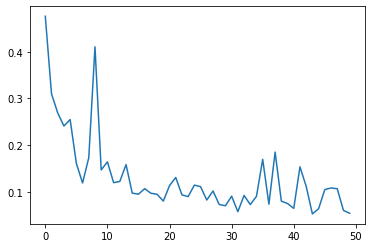

In [20]:
plt.plot(losses)

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [21]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


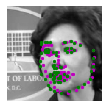

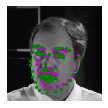

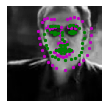

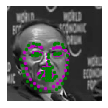

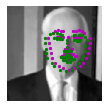

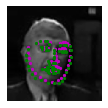

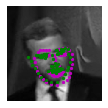

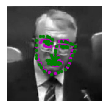

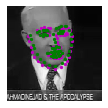

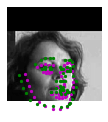

In [22]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [23]:
## TODO: change the name to something uniqe for each new model
# model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), root_folder+model_name)

In [24]:
root_folder+model_name

'/scratch/prathyuakundi/Udacity/CV/P1_Facial_Keypoints/keypoints_model_1.pt'

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: 
I have used Adam optimizer and Smooth L1 loss. I tried initially with MSE loss, but then observed that model with Smooth L1 loss has faster convergence. Also it has advantage over MSE loss by avoid exploding gradients and is less sensitive to large errors/outliers

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: 
* The architecture has 5 convolution layers with 3x3 receptive field and with stride and padding equals to 1.Each convolution layer has 'relu' as non-linear activation function and these are followed my max pooling layers. Max pooling is done with 2x2 window size with stride as 2. All the convolution layers except for input layer undergoes batch normalization.
* The convolution layers are then followed by 3 fully connected layers with 1024, 512 and 136 out_features respectively.
* Since the training data is small, no additional layers were added to avoid overfitting of data


### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: 
* Training was initially started with few epochs and the loss profile is then observed and number of epochs are gradually increased until overall loss is not increasing. 
* Cuda issues got arised when I used a very large batch_size and hence I used batch_size as 10.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.19168466  0.24137563 -0.26065573]
 [-0.13100566  0.20485352  0.19896401]
 [-0.3078382  -0.35735983  0.08085918]]
(3, 3)


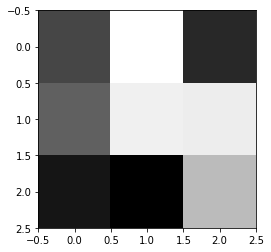

In [45]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

In [46]:
len(test_images)

10

Text(0.5, 1.0, 'Filtered Image')

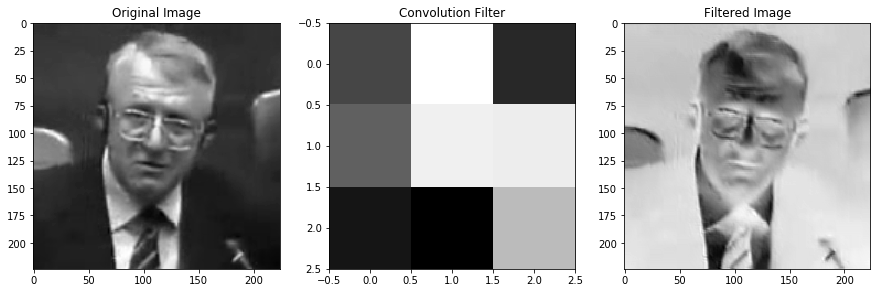

In [47]:
##TODO: load in and display any image from the transformed test dataset
import cv2
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
image = test_images[7].data.cpu().numpy()
image = np.squeeze(image)
filtered = cv2.filter2D(image, -1, w[filter_index][0])
f,ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(w[filter_index][0], cmap='gray')
ax[1].set_title('Convolution Filter')

ax[2].imshow(filtered, cmap='gray')
ax[2].set_title('Filtered Image')

In [48]:
w[filter_index][0]

array([[-0.19168466,  0.24137563, -0.26065573],
       [-0.13100566,  0.20485352,  0.19896401],
       [-0.3078382 , -0.35735983,  0.08085918]], dtype=float32)

In [49]:
np.sum(w[filter_index][0])

-0.52249175

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: 
* The filter seems to highlight the edges oriented at a certain angle and also since sum of the filter is less than 0, the lighter pixels became dark and vice-versa, giving an overall a negative shade effect.
* Using this kind of filter, subtle changes brightness can be easily observed, for example in above image, the change in intensity levels near forehead can be easily discernable.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!